In [1]:
!pip install seaborn
!pip install modin[ray]
!pip install ray
!pip install imbalanced-learn
!pip install pandas-profiling

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached modin-0.32.0-py3-none-any.whl.metadata (17 kB)
Using cached modin-0.32.0-py3-none-any.whl (1.1 MB)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)
  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached visions-0.7.4-py3-none-any.whl.metadata (5.9 kB)
  Using cached htmlmin-0.1.12-py3-none-any.whl
  Using cached missingno-0.5.2-py3-none-any.whl.metadata (639 bytes)
  Using cached phik-0.12.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached tangled_up_in_unicode-0.2.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached multimethod-1.12-py3-none-any.whl.metadata (9.6 kB)
  Using cached ImageHash-4.3.1-py2.py3-none-any.whl.metada

In [2]:
!pip install ray[tune]


In [53]:
!pip install --upgrade joblib

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-timeseries 1.1.1 requires gluonts==0.15.1, but you have gluonts 0.14.3 which is incompatible.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.


# 1. Loading Libraries

In [152]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, f1_score, roc_auc_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import pandas as _pd
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

In [5]:
!mkdir /mnt/sagemaker-nvme/ray_temp
!mkdir /mnt/sagemaker-nvme/ray_temp_plasma

mkdir: cannot create directory ‘/mnt/sagemaker-nvme/ray_temp’: File exists


In [6]:
import json
import modin.pandas as pd
import ray

ray_info = ray.init(
    _system_config={
    "object_spilling_config": json.dumps(
        {"type": "filesystem", "params": {"directory_path": "/mnt/sagemaker-nvme/ray_lstm_spelling"}},
    )
    },
    object_store_memory=(214748364800), # Allocates 200 GB to Ray Plasma memory, which stores object on available memory space.
    _temp_dir="/mnt/sagemaker-nvme/ray_temp",
    _plasma_directory="/mnt/sagemaker-nvme/ray_temp_plasma",
    ignore_reinit_error=True
)

2024-10-01 03:23:36,694	INFO services.py:2034 -- object_store_memory is not verified when plasma_directory is set.
2024-10-01 03:23:36,843	INFO worker.py:1762 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


In [7]:
ray_info

Python version:,3.11.9
Ray version:,2.31.0
Dashboard:,http://127.0.0.1:8266


In [8]:
ray_info.address_info

{'node_ip_address': '169.255.255.2',
 'raylet_ip_address': '169.255.255.2',
 'redis_address': None,
 'object_store_address': '/mnt/sagemaker-nvme/ray_temp/session_2024-10-01_03-23-35_034032_198/sockets/plasma_store',
 'raylet_socket_name': '/mnt/sagemaker-nvme/ray_temp/session_2024-10-01_03-23-35_034032_198/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/mnt/sagemaker-nvme/ray_temp/session_2024-10-01_03-23-35_034032_198',
 'metrics_export_port': 63359,
 'gcs_address': '169.255.255.2:65190',
 'address': '169.255.255.2:65190',
 'dashboard_agent_listen_port': 52365,
 'node_id': 'cecf40666f6153313db3c198c332407333e921c95bbd341491545d85'}

In [9]:
NVMe_PATH = '/mnt/sagemaker-nvme/'

In [10]:
# Creating folder for temp storage while fitting GridSearch
! mkdir /mnt/sagemaker-nvme/tempGridSearch

In [45]:
NVMe_PATH = '/mnt/sagemaker-nvme/'

# 2. Loading Processed data, and exploring the features:

## 2.1. Loading data:

In [12]:
training_file_name = "training_after_preproc.csv"
testing_file_name = "testing_after_preproc.csv"

In [13]:
NVMe_Training_file_Path = NVMe_PATH+training_file_name
NVMe_Testing_file_Path = NVMe_PATH+testing_file_name

print(NVMe_Training_file_Path)
print(NVMe_Testing_file_Path)

/mnt/sagemaker-nvme/training_after_preproc.csv
/mnt/sagemaker-nvme/testing_after_preproc.csv


In [14]:
%%time
if os.path.exists(NVMe_Training_file_Path):
    pass
else:
    !aws s3 cp s3://melbahae-capstone/Datasets/training_after_preproc.csv /mnt/sagemaker-nvme/

if os.path.exists(NVMe_Testing_file_Path):
    pass
else:
    !aws s3 cp s3://melbahae-capstone/Datasets/testing_after_preproc.csv /mnt/sagemaker-nvme/


download: s3://melbahae-capstone/Datasets/training_after_preproc.csv to ../../../mnt/sagemaker-nvme/training_after_preproc.csv
download: s3://melbahae-capstone/Datasets/testing_after_preproc.csv to ../../../mnt/sagemaker-nvme/testing_after_preproc.csv
CPU times: user 12.4 s, sys: 10.5 s, total: 23 s
Wall time: 2min 38s


In [15]:
%%time 

training_df = pd.read_csv(NVMe_Training_file_Path)

CPU times: user 30.7 s, sys: 27.9 s, total: 58.6 s
Wall time: 1min 51s


In [16]:
%%time

testing_df = pd.read_csv(NVMe_Testing_file_Path)

CPU times: user 12.1 s, sys: 12 s, total: 24.1 s
Wall time: 43.3 s


In [20]:
training_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 50052497 entries, 0 to 50052496
Columns: 160 entries, Total Fwd Packets to Protocol_UDP
dtypes: bool(105), float64(47), int64(8)
memory usage: 25.4 GB


In [21]:
testing_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 19963266 entries, 0 to 19963265
Columns: 160 entries, Total Fwd Packets to Protocol_UDP
dtypes: bool(105), float64(47), int64(8)
memory usage: 10.1 GB


## 2.2. Checking the features and confirming their dtypes:

In [19]:
training_df.head()

,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Source Port IANA Range_Registered,Source Port IANA Range_Dynamic/Private,Source Port IANA Range_Unknown,Destination Port IANA Range_Well-Known,Destination Port IANA Range_Registered,Destination Port IANA Range_Dynamic/Private,Destination Port IANA Range_Unknown,Protocol_HOPOPT,Protocol_TCP,Protocol_UDP
0,2,0,766.0,0.0,383.0,383.0,383.0,0.0,0.0,0.0,...,False,True,False,False,True,False,False,False,False,True
1,2,0,778.0,0.0,389.0,389.0,389.0,0.0,0.0,0.0,...,True,False,False,False,True,False,False,False,False,True
2,2,0,750.0,0.0,375.0,375.0,375.0,0.0,0.0,0.0,...,True,False,False,False,True,False,False,False,False,True
3,2,0,738.0,0.0,369.0,369.0,369.0,0.0,0.0,0.0,...,False,True,False,False,True,False,False,False,False,True
4,2,0,750.0,0.0,375.0,375.0,375.0,0.0,0.0,0.0,...,False,True,False,False,False,True,False,False,False,True


In [24]:
training_df.dtypes[:60]

Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets    float64
Total Length of Bwd Packets    float64
Fwd Packet Length Max          float64
Fwd Packet Length Min          float64
Fwd Packet Length Mean         float64
Fwd Packet Length Std          float64
Bwd Packet Length Max          float64
Bwd Packet Length Min          float64
Bwd Packet Length Mean         float64
Bwd Packet Length Std          float64
Flow Bytes/s                   float64
Flow Packets/s                 float64
Flow IAT Mean                  float64
Flow IAT Std                   float64
Flow IAT Max                   float64
Flow IAT Min                   float64
Fwd IAT Total                  float64
Fwd IAT Mean                   float64
Fwd IAT Std                    float64
Fwd IAT Max                    float64
Fwd IAT Min                    float64
Bwd IAT Total                  float64
Bwd IAT Mean                   float64
Bwd IAT Std              

In [25]:
training_df.dtypes[60:120]

Source IP Class_D                     bool
Source IP Class_E                     bool
Source IP Class_Unknown               bool
Destination IP Class_A                bool
Destination IP Class_B                bool
Destination IP Class_C                bool
Destination IP Class_D                bool
Destination IP Class_E                bool
Destination IP Class_Unknown          bool
Source IP Reserved_Private            bool
Source IP Reserved_Multicast          bool
Source IP Reserved_Loopback           bool
Source IP Reserved_Link-local         bool
Source IP Reserved_Reserved           bool
Source IP Reserved_Broadcast          bool
Source IP Reserved_DHCP/Zeros         bool
Source IP Reserved_Public             bool
Destination IP Reserved_Private       bool
Destination IP Reserved_Multicast     bool
Destination IP Reserved_Loopback      bool
Destination IP Reserved_Link-local    bool
Destination IP Reserved_Reserved      bool
Destination IP Reserved_Broadcast     bool
Destination

In [26]:
training_df.dtypes[120:]

Source Port Category_HTTP                      bool
Source Port Category_HTTP Alternate            bool
Source Port Category_HTTPS                     bool
Source Port Category_HTTPS Alternate           bool
Source Port Category_MS SQL                    bool
Source Port Category_MySQL                     bool
Source Port Category_NTP                       bool
Source Port Category_PostgreSQL                bool
Source Port Category_RDP                       bool
Source Port Category_SSH                       bool
Source Port Category_TFTP                      bool
Source Port Category_Zero                      bool
Source Port Category_Others                    bool
Destination Port Category_DHCP                 bool
Destination Port Category_DNS                  bool
Destination Port Category_FTP                  bool
Destination Port Category_HTTP                 bool
Destination Port Category_HTTP Alternate       bool
Destination Port Category_HTTPS                bool
Destination 

In [27]:
( training_df.isnull().sum().sum(), training_df.isnull().sum().sum() )

(0, 0)

In [28]:
training_df["is_attack"].value_counts() , testing_df["is_attack"].value_counts()

the groupby keys will be sorted anyway, although the 'sort=False' was passed. See the following issue for more details: https://github.com/modin-project/modin/issues/3571.


(is_attack
 True     49995744
 False       56753
 Name: count, dtype: int64,
 is_attack
 True     19910729
 False       52537
 Name: count, dtype: int64)

In [29]:
# Checking the ratio of benign traffic to attack traffic:


training_df["is_attack"].value_counts(normalize=True) , testing_df["is_attack"].value_counts(normalize=True)

(is_attack
 True     0.998866
 False    0.001134
 Name: proportion, dtype: float64,
 is_attack
 True     0.997368
 False    0.002632
 Name: proportion, dtype: float64)

## 2.3. Dropping columns with single value:

In [27]:
%%time
# Checking for columns with single value in training_df:

single_value_cols = [col for col in training_df.columns if training_df[col].nunique() <= 1]

CPU times: user 18.4 s, sys: 2.4 s, total: 20.8 s
Wall time: 1min 8s


In [28]:
single_value_cols

['Source IP Class_D',
 'Source IP Class_E',
 'Destination IP Class_Unknown',
 'Source IP Reserved_Multicast',
 'Source IP Reserved_Loopback',
 'Source IP Reserved_Link-local',
 'Source IP Reserved_Reserved',
 'Source IP Reserved_Broadcast',
 'Source IP Reserved_DHCP/Zeros',
 'Destination IP Reserved_Loopback',
 'Destination IP Reserved_Link-local',
 'Destination IP Reserved_Reserved',
 'Destination IP Reserved_Broadcast',
 'Destination IP Reserved_DHCP/Zeros',
 'Source Port Category_FTP',
 'Source Port Category_MS SQL',
 'Source Port Category_MySQL',
 'Source Port IANA Range_Unknown',
 'Destination Port IANA Range_Unknown']

In [29]:
# dropping common_cols from training and testing datasets:

training_df = training_df.drop(columns=single_value_cols)
testing_df = testing_df.drop(columns=single_value_cols)
(training_df.shape, testing_df.shape)

((50052497, 141), (19963266, 141))

In [30]:
training_df.info(), testing_df.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 50052497 entries, 0 to 50052496
Columns: 141 entries, Total Fwd Packets to Protocol_UDP
dtypes: bool(86), float32(20), float64(27), int16(2), int32(1), int8(5)
memory usage: 16.0 GB
<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 19963266 entries, 0 to 19963265
Columns: 141 entries, Total Fwd Packets to Protocol_UDP
dtypes: bool(86), float32(18), float64(29), int16(2), int32(1), int8(5)
memory usage: 6.5 GB


(None, None)

## 2.5. Converting bool columns to integer

In [31]:
# Converting bool columns to integer
train_bool_cols = training_df.select_dtypes(include=['bool']).columns
training_df[train_bool_cols] = training_df[train_bool_cols].astype(int)

testing_bool_cols = testing_df.select_dtypes(include=['bool']).columns
testing_df[train_bool_cols] = testing_df[train_bool_cols].astype(int)

# 3. Training Decision Tree Model:

The boolean values in the Modin dataframe reporting issues with scikit library. Therfore converting them back to Integer. 

### Addressing Imbalanced data through two main techniques:

- Scoring Metrics: Choosing scoring metrics to measure model's performance on that are not skewed by the imbalanced classes, or wiegh the minority class.
    - **Precision:** as it includes FP.
    - **F1_macro:** standard F1, better for imbalanaced data.
    - **Flase Positive Rate:** The most important metric in our case, to check the check the number of benign traffic classified as Attack traffic. 

- Class Wieght:

    - "balanced" approach:
        weight for class= n_samples / ( n_classes x n_samples_per_class )
  

## 3.2. Creating scoring function for FPR and TPR:

In [32]:
# Custom scoring function for False Positive Rate (FPR)
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)  # False Positive Rate calculation
    return fpr

# Wrap the custom FPR function with make_scorer
fpr_scorer = make_scorer(false_positive_rate, greater_is_better=False)

In [33]:
# Define custom function for True Positive Rate (TPR)
def true_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    return tpr
tpr_scorer = make_scorer(true_positive_rate, greater_is_better=True) 

In [34]:
SCORING = {
    'precision': 'precision',           
    'f1': 'f1',                          # Weighted F1 scorer, gives more importance to majority class. Not used.
    'f1_macro': 'f1_macro',              # Macro/Standard F1, gives equal weigtht to each class, regardless of the number of instances in each class.
    'accuracy': 'accuracy',				 # Accuracy
    'false_positive_rate': fpr_scorer,	 # FP Rate scorer
    'tpr': tpr_scorer,                   # TP Rate scorer
}

REFIT = "false_positive_rate"

## 3.3. Function to train DT with different Parameters:

In [48]:
from ray.util.joblib import register_ray

In [49]:
# Register Ray with joblib for parallelism
register_ray()

In [50]:
def split_train_test_df(train_df, test_df):
    X_train = train_df.drop("is_attack", axis=1)
    y_train = train_df['is_attack']
    
    X_test = test_df.drop("is_attack", axis=1)
    y_test = test_df["is_attack"]

    return X_train, y_train, X_test, y_test


def train_grid_search(X_train, y_train,param_grid, n_jobs=5):
    temp_dir = '/mnt/sagemaker-nvme/'
    # Initialize Decision Tree
    dt_model = DecisionTreeClassifier(
        criterion="entropy", # choosing entropy as the dataset is imbalanced.
        random_state=42
    )

    # GridSearchCV with parallel processing with n_jobs
    grid_search = GridSearchCV(estimator=dt_model, 
                               param_grid=param_grid, 
                               cv=3, 
                               scoring=SCORING,
                               refit = REFIT,
                               n_jobs=n_jobs,
                               verbose=2,
                              ) 
    if n_jobs > 1:
        # Use the 'ray' backend only when parallelism is needed
        with joblib.parallel_config(backend="ray", verbose=1, temp_dir="/mnt/sagemaker-nvme/tempGridSearch"):
            return grid_search.fit(X_train, y_train)
    else:
        # Avoiding ray if number of jobs=1 as it lead the gridsearch to stuck after completion.
        return grid_search.fit(X_train, y_train)

## 3.4. Evaluating Top parameters on a subset of data:

Using a smaller version of the dataset to evaluate check the most optimum hyperparameters to chose top three from to train on the full dataset.

### 3.4.1. Splitting the data and Traning models:

In [38]:
# Taking a sample from Training and testing data:

train_sample = training_df.sample(frac=0.1, random_state=42)
test_sample = testing_df.sample(frac=0.1, random_state=42)

X_train, y_train, X_test, y_test = split_train_test_df(train_sample, test_sample)

In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5005250, 140), (5005250,), (1996327, 140), (1996327,))

In [27]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50052497, 140), (50052497,), (19963266, 140), (19963266,))

In [48]:
%%time
param_grid = {
    'max_depth': [None, 10, 20,],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, 'balanced']
}
fitted_grid_search = train_grid_search(X_train, y_train, param_grid)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
CPU times: user 1min 9s, sys: 5.89 s, total: 1min 14s
Wall time: 23min 5s


### 3.4.2. Checking the results

In [49]:
# Use the best model found by GridSearchCV for predictions
best_dt_model = fitted_grid_search.best_estimator_

# Predict using test data
y_pred_dt = best_dt_model.predict(X_test)

# Print accuracy and classification report
print("Decision Tree Model Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt)

Decision Tree Model Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5288
           1       1.00      1.00      1.00   1991039

    accuracy                           1.00   1996327
   macro avg       1.00      1.00      1.00   1996327
weighted avg       1.00      1.00      1.00   1996327



In [50]:
# Convert cv_results_ into a DataFrame for easier manipulation

cv_results_df = pd.DataFrame(fitted_grid_search.cv_results_)

In [52]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'param_max_depth', 'param_min_samples_leaf',
       'param_min_samples_split', 'params', 'split0_test_precision',
       'split1_test_precision', 'split2_test_precision', 'mean_test_precision',
       'std_test_precision', 'rank_test_precision', 'split0_test_f1',
       'split1_test_f1', 'split2_test_f1', 'mean_test_f1', 'std_test_f1',
       'rank_test_f1', 'split0_test_f1_macro', 'split1_test_f1_macro',
       'split2_test_f1_macro', 'mean_test_f1_macro', 'std_test_f1_macro',
       'rank_test_f1_macro', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy',
       'rank_test_accuracy', 'split0_test_false_positive_rate',
       'split1_test_false_positive_rate', 'split2_test_false_positive_rate',
       'mean_test_false_positive_rate', 'std_test_false_positive_rate',
       'rank_test_false_positive_rate', 'split0

In [53]:
# Backing up CV Results:

cv_results_df.to_csv("Datasets/DT_CV_Result.csv", index=False)

In [116]:
#  Loading it in case of Kernel restart
# cv_results_df = pd.read_csv("Datasets/DT_CV_Result.csv")

In [140]:
# Filling null values under param_max_depth with None:

cv_results_df['param_max_depth']  = cv_results_df['param_max_depth'].astype(str)
# Changing specified columns to category type
cv_results_df[['param_class_weight', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split']] = cv_results_df[['param_class_weight', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split']].astype('category')

cv_results_df['mean_test_false_positive_rate'] = cv_results_df['mean_test_false_positive_rate'] * -1

In [128]:
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_precision,...,split2_test_false_positive_rate,mean_test_false_positive_rate,std_test_false_positive_rate,rank_test_false_positive_rate,split0_test_tpr,split1_test_tpr,split2_test_tpr,mean_test_tpr,std_test_tpr,rank_test_tpr
0,31.433848,0.256634,2.006478,0.018744,NaN,nan,1,2,"{'class_weight': None, 'max_depth': None, 'min...",1.0,...,-0.0,-0.0,0.0,1,1.0,1.0,1.0,1.0,0.0,1
1,31.480416,0.061726,2.019390,0.046413,NaN,nan,1,10,"{'class_weight': None, 'max_depth': None, 'min...",1.0,...,-0.0,-0.0,0.0,1,1.0,1.0,1.0,1.0,0.0,1
2,31.475637,0.465655,2.026297,0.040672,NaN,nan,1,20,"{'class_weight': None, 'max_depth': None, 'min...",1.0,...,-0.0,-0.0,0.0,1,1.0,1.0,1.0,1.0,0.0,1
3,31.824487,0.174390,2.005208,0.033734,NaN,nan,5,2,"{'class_weight': None, 'max_depth': None, 'min...",1.0,...,-0.0,-0.0,0.0,1,1.0,1.0,1.0,1.0,0.0,1
4,31.704158,0.549392,2.027495,0.025215,NaN,nan,5,10,"{'class_weight': None, 'max_depth': None, 'min...",1.0,...,-0.0,-0.0,0.0,1,1.0,1.0,1.0,1.0,0.0,1


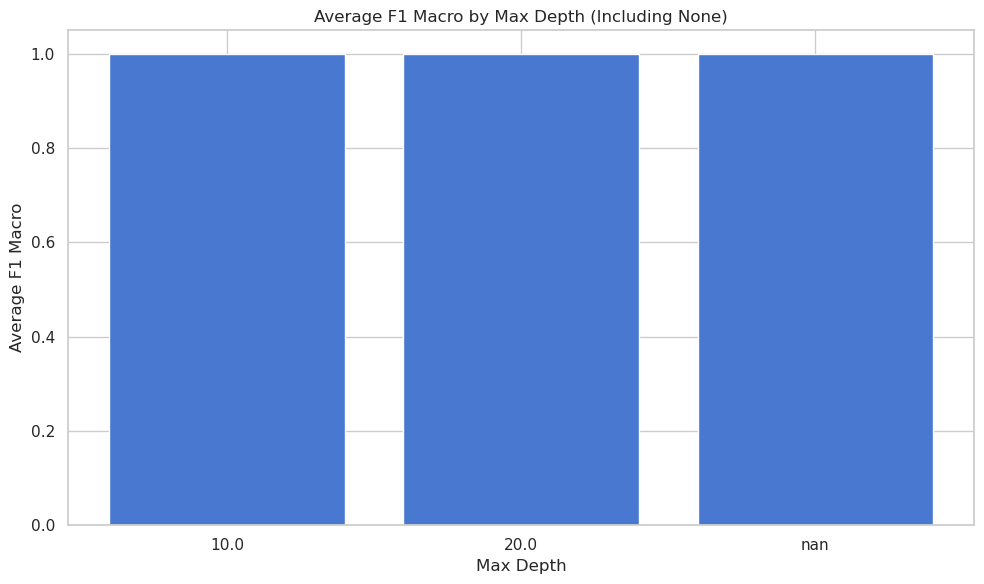

In [123]:

# Grouping by Max Depth and averaging F1 Macro values
df_grouped = cv_results_df.groupby('param_max_depth')['mean_test_f1_macro'].mean().reset_index()

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(df_grouped['param_max_depth'], df_grouped['mean_test_f1_macro'], color='b')

# Adding labels and title
plt.xlabel('Max Depth')
plt.ylabel('Average F1 Macro')
plt.title('Average F1 Macro by Max Depth (Including None)')

# Displaying the plot
plt.tight_layout()
plt.show()


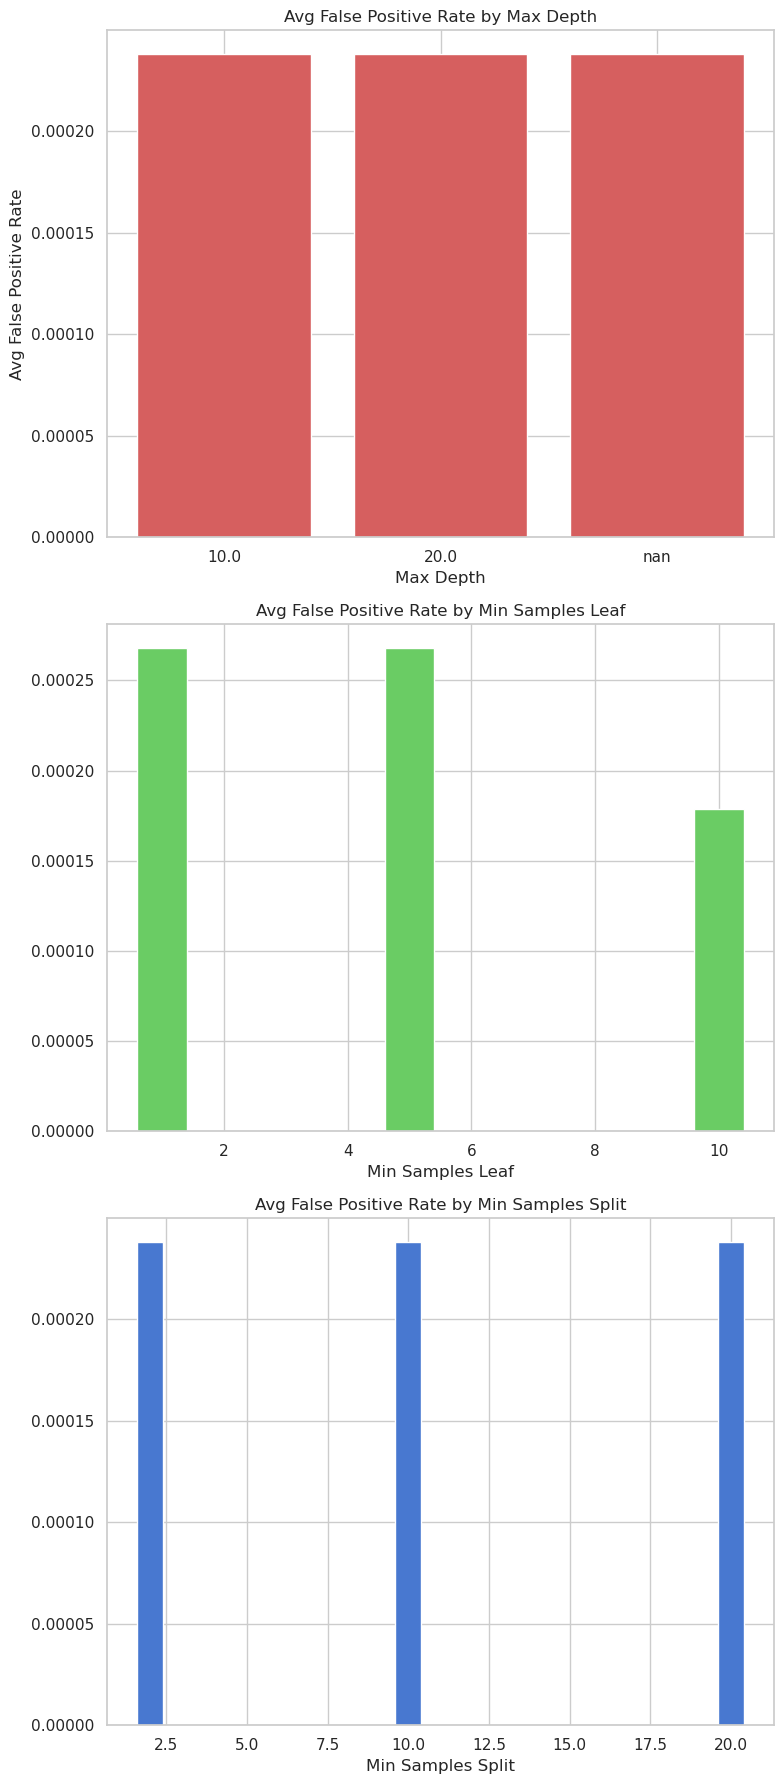

In [142]:
# Grouping by Max Depth, Min Samples Leaf, and Min Samples Split, and averaging False Positive Rate values
df_grouped_depth = cv_results_df.groupby('param_max_depth')['mean_test_false_positive_rate'].mean().reset_index()
df_grouped_leaf = cv_results_df.groupby('param_min_samples_leaf')['mean_test_false_positive_rate'].mean().reset_index()
df_grouped_split = cv_results_df.groupby('param_min_samples_split')['mean_test_false_positive_rate'].mean().reset_index()

# Creating a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

# Plot for Max Depth
axes[0].bar(df_grouped_depth['param_max_depth'], df_grouped_depth['mean_test_false_positive_rate'], color='r')
axes[0].set_title('Avg False Positive Rate by Max Depth')
axes[0].set_xlabel('Max Depth')
axes[0].set_ylabel('Avg False Positive Rate')

# Plot for Min Samples Leaf
axes[1].bar(df_grouped_leaf['param_min_samples_leaf'], df_grouped_leaf['mean_test_false_positive_rate'], color='g')
axes[1].set_title('Avg False Positive Rate by Min Samples Leaf')
axes[1].set_xlabel('Min Samples Leaf')

# Plot for Min Samples Split
axes[2].bar(df_grouped_split['param_min_samples_split'], df_grouped_split['mean_test_false_positive_rate'], color='b')
axes[2].set_title('Avg False Positive Rate by Min Samples Split')
axes[2].set_xlabel('Min Samples Split')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()


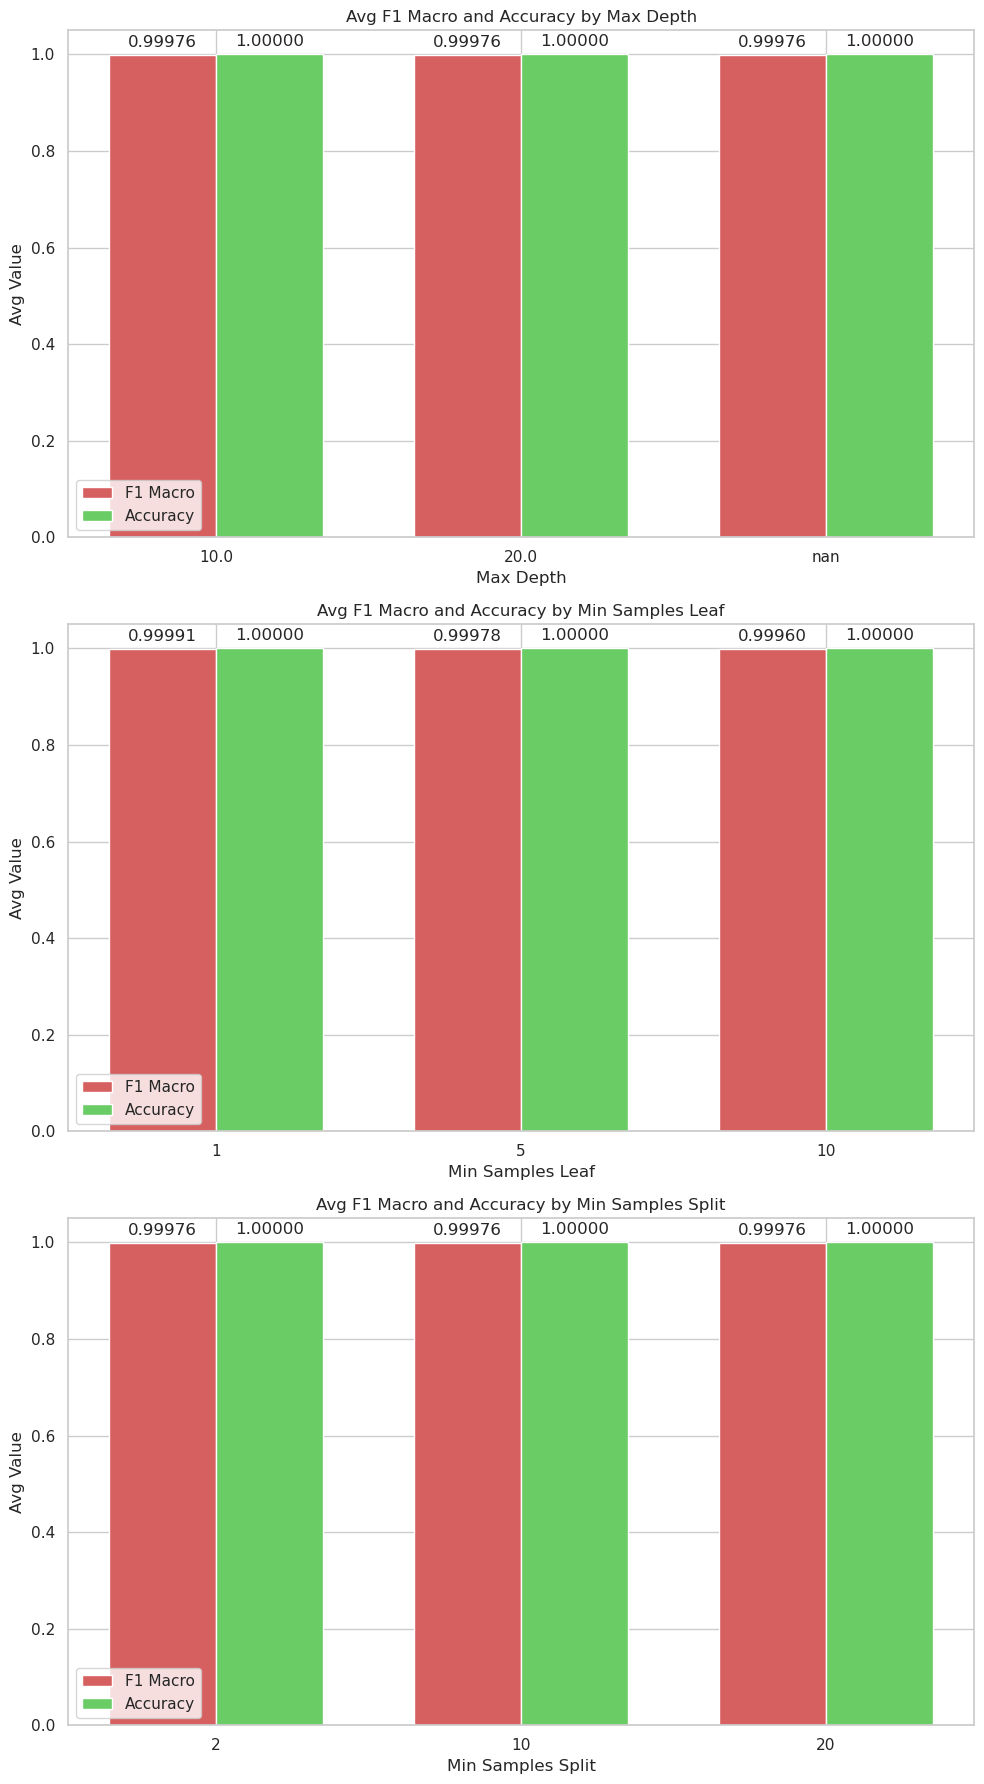

In [150]:
# Grouping by Max Depth, Min Samples Leaf, and Min Samples Split for both F1 Macro and Accuracy
df_grouped_depth = cv_results_df.groupby('param_max_depth')[['mean_test_f1_macro', 'mean_test_accuracy']].mean().reset_index()
df_grouped_leaf = cv_results_df.groupby('param_min_samples_leaf')[['mean_test_f1_macro', 'mean_test_accuracy']].mean().reset_index()
df_grouped_split = cv_results_df.groupby('param_min_samples_split')[['mean_test_f1_macro', 'mean_test_accuracy']].mean().reset_index()

# Creating the plots in a vertical layout
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

bar_width = 0.35
index_depth = range(len(df_grouped_depth))
index_leaf = range(len(df_grouped_leaf))
index_split = range(len(df_grouped_split))

# Plot for Max Depth (F1 and Accuracy side by side)
axes[0].bar(index_depth, df_grouped_depth['mean_test_f1_macro'], bar_width, label='F1 Macro', color='r')
axes[0].bar([i + bar_width for i in index_depth], df_grouped_depth['mean_test_accuracy'], bar_width, label='Accuracy', color='g')
axes[0].set_title('Avg F1 Macro and Accuracy by Max Depth')
axes[0].set_xlabel('Max Depth')
axes[0].set_ylabel('Avg Value')
axes[0].set_xticks([i + bar_width / 2 for i in index_depth])
axes[0].set_xticklabels(df_grouped_depth['param_max_depth'])
axes[0].legend()

# Adding values on top of each bar for Max Depth
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.5f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')

# Plot for Min Samples Leaf (F1 and Accuracy side by side)
axes[1].bar(index_leaf, df_grouped_leaf['mean_test_f1_macro'], bar_width, label='F1 Macro', color='r')
axes[1].bar([i + bar_width for i in index_leaf], df_grouped_leaf['mean_test_accuracy'], bar_width, label='Accuracy', color='g')
axes[1].set_title('Avg F1 Macro and Accuracy by Min Samples Leaf')
axes[1].set_xlabel('Min Samples Leaf')
axes[1].set_ylabel('Avg Value')
axes[1].set_xticks([i + bar_width / 2 for i in index_leaf])
axes[1].set_xticklabels(df_grouped_leaf['param_min_samples_leaf'])
axes[1].legend()

# Adding values on top of each bar for Min Samples Leaf
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.5f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')

# Plot for Min Samples Split (F1 and Accuracy side by side)
axes[2].bar(index_split, df_grouped_split['mean_test_f1_macro'], bar_width, label='F1 Macro', color='r')
axes[2].bar([i + bar_width for i in index_split], df_grouped_split['mean_test_accuracy'], bar_width, label='Accuracy', color='g')
axes[2].set_title('Avg F1 Macro and Accuracy by Min Samples Split')
axes[2].set_xlabel('Min Samples Split')
axes[2].set_ylabel('Avg Value')
axes[2].set_xticks([i + bar_width / 2 for i in index_split])
axes[2].set_xticklabels(df_grouped_split['param_min_samples_split'])
axes[2].legend()

# Adding values on top of each bar for Min Samples Split
for p in axes[2].patches:
    axes[2].annotate(format(p.get_height(), '.5f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), textcoords = 'offset points')

# Adjusting layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

## Chosing best models to test with the full dataset:

> **Avoiding models with F1_score of `1`, as they potential suffer from overfitting**

In [148]:
best_models = cv_results_df.sort_values(by="mean_test_false_positive_rate", ascending=True).reset_index(drop=True)

best_models[['param_class_weight', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_false_positive_rate', "split1_test_f1_macro",'mean_test_accuracy', "mean_test_precision",]].head()

,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_false_positive_rate,split1_test_f1_macro,mean_test_accuracy,mean_test_precision
0,NaN,nan,1,2,-0.0,1.0,1.0,1.0
1,NaN,nan,1,10,-0.0,1.0,1.0,1.0
2,NaN,nan,1,20,-0.0,1.0,1.0,1.0
3,NaN,nan,5,2,-0.0,1.0,1.0,1.0
4,NaN,nan,5,10,-0.0,1.0,1.0,1.0


In [135]:
# Filtering out models with accuracy of 1, which suggests overfiting, and sorting it by mean test F1 macro score
no_overfit_models = best_models[best_models["mean_test_accuracy"] != 1].reset_index(drop=True)

# Display the top models with their hyperparameters
no_overfit_models[['param_class_weight', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_false_positive_rate', "mean_test_f1_macro",'mean_test_accuracy', "mean_test_precision", "mean_fit_time"]].head(20)


,param_class_weight,param_max_depth,param_min_samples_leaf,param_min_samples_split,mean_test_false_positive_rate,mean_test_f1_macro,mean_test_accuracy,mean_test_precision,mean_fit_time
0,balanced,10.0,10,2,0.000357,0.999197,0.999996,1.000000,38.014519
1,balanced,10.0,10,10,0.000357,0.999197,0.999996,1.000000,37.995716
2,balanced,nan,10,20,0.000357,0.999197,0.999996,1.000000,38.042239
3,balanced,nan,10,10,0.000357,0.999197,0.999996,1.000000,37.957982
4,balanced,nan,10,2,0.000357,0.999197,0.999996,1.000000,38.104373
5,balanced,20.0,10,20,0.000357,0.999197,0.999996,1.000000,37.756799
6,balanced,10.0,10,20,0.000357,0.999197,0.999996,1.000000,38.180041
7,balanced,20.0,10,10,0.000357,0.999197,0.999996,1.000000,37.874183
8,balanced,20.0,10,2,0.000357,0.999197,0.999996,1.000000,38.077152
9,balanced,nan,1,2,0.000535,0.999821,0.999999,0.999999,38.053355


> **Note:** The negative values observed for the *False Positive Rate (FPR)* in GridSearchCV results are due to how scikit-learn's make_scorer function handles the greater_is_better parameter.  when greater_is_better=False, scikit-learn multiplies the metric by -1 internally to convert it into a score where higher values are better (since optimization routines are designed to maximize the score).

**Which models to train on the full dataset:**
Top 9 models have the same FPR, therefore, chosing the model that is most restrictive to avoid overfitting.

Model#1: 
- param_class_weight balanaced
- param_max_depth 10
- param_min_samples_leaf 10 	
- param_min_samples_split 2

--

Model#2: 

Also chosing model,index-19, because it is restrictive and have higher F1 _Marco than the previous one, with slightly less FPR.

- param_class_weight balanaced
- param_max_depth 10
- param_min_samples_leaf 1	
- param_min_samples_split 20

--

Model#3: 

finally chosing model index-10, because its parameter is differet to the ones above, and it has the same F1_macro, and FPR.

- param_class_weight balanaced
- param_max_depth 20
- param_min_samples_leaf 5	
- param_min_samples_split 10

## Training Model based on the whole dataset:

In [36]:
%%time

X_train, y_train, X_test, y_test = split_train_test_df(training_df, testing_df)

CPU times: user 422 ms, sys: 3.8 ms, total: 426 ms
Wall time: 397 ms


In [37]:
%%time

X_train.shape, y_train.shape , X_test.shape, y_test.shape

CPU times: user 79 μs, sys: 0 ns, total: 79 μs
Wall time: 86.5 μs


((50052497, 140), (50052497,), (19963266, 140), (19963266,))

In [61]:
%%time
param_grid = [
    {"class_weight":"balanced", 'max_depth': 10, 'min_samples_leaf': 10,'min_samples_split': 2}, 
    {"class_weight":"balanced", 'max_depth': 10, 'min_samples_leaf': 1,'min_samples_split': 20}, 
    {"class_weight":"balanced", 'max_depth': 20, 'min_samples_leaf': 5,'min_samples_split': 10} 
]


# List to store trained models
trained_models = []

# Loop over the param_grid and train each Decision Tree model
for idx, params in enumerate(param_grid):
    
    # Save the trained model to disk
    model_filename = f"decision_tree_models/decision_tree_model_{idx + 1}.joblib"

    # Check if the model file already exists
    if os.path.exists(model_filename):
        print(f"Model {idx + 1} already exists. Skipping training.")
        continue  # Skip this iteration if the model is already saved
    
    # Initialize Decision Tree model with the specified parameters
    dt_model = DecisionTreeClassifier(
        criterion="entropy",  # Using entropy as the criterion since the dataset is imbalanced
        class_weight=params['class_weight'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        min_samples_split=params['min_samples_split'],
        random_state=42
    )

    # Fit the model
    print(f"Training model {idx + 1} with params: {params}")
    dt_model.fit(X_train, y_train)


    joblib.dump(dt_model, model_filename)
    print(f"Model {idx + 1} saved as {model_filename}")

    # Append the trained model to the list
    trained_models.append(dt_model)

print("Training completed for all models.")

Model 1 already exists. Skipping training.
Model 2 already exists. Skipping training.
Training model 3 with params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 10}
Model 3 saved as decision_tree_model_3.joblib
Training completed for all models.
CPU times: user 5min 46s, sys: 1min 8s, total: 6min 54s
Wall time: 6min 52s


In [154]:
# Testing the model and checking their performance:

# List of filenames for the trained models
model_filenames = [
    "decision_tree_model_1.joblib",
    "decision_tree_model_2.joblib",
    "decision_tree_model_3.joblib"
]

# Placeholder to store the evaluation results
results = []

# Loop through the saved models and evaluate them
for idx, model_filename in enumerate(model_filenames):
    # Load the trained model
    if os.path.exists(model_filename):
        dt_model = joblib.load(model_filename)
        print(f"Testing model {idx + 1} from {model_filename}")

        # Perform predictions
        y_pred = dt_model.predict(X_test)

        # Calculate Accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Calculate F1 Score
        f1 = f1_score(y_test, y_pred)

        # Calculate confusion matrix for TPR and FPR
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        tpr = tp / (tp + fn)  # Sensitivity, hit rate, recall
        fpr = fp / (fp + tn)  # Fall-out, false positive rate

        # Append the results to the list, including the parameters for each model
        results.append({
            'Model': f'Model {idx + 1}',
            'Max Depth': param_grid[idx]['max_depth'],
            'Min Samples Leaf': param_grid[idx]['min_samples_leaf'],
            'Min Samples Split': param_grid[idx]['min_samples_split'],
            'Accuracy': accuracy,
            'F1 Score': f1,
            'True Positive Rate (TPR)': tpr,
            'False Positive Rate (FPR)': fpr
        })

# Convert the results into a Pandas DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

# Optionally, save the results DataFrame to a CSV file
results_df.to_csv("decision_tree_models/model_evaluation_results_with_params.csv", index=False)

print("Results saved to 'model_evaluation_results_with_params.csv'.")

Testing model 1 from decision_tree_model_1.joblib
Testing model 2 from decision_tree_model_2.joblib
Testing model 3 from decision_tree_model_3.joblib
     Model  Max Depth  Min Samples Leaf  Min Samples Split  Accuracy  \
0  Model 1         10                10                  2  0.940085   
1  Model 2         10                 1                 20  0.999987   
2  Model 3         20                 5                  0  0.999973   

   F1 Score  True Positive Rate (TPR)  False Positive Rate (FPR)  
0  0.969034                  0.939949                   0.008603  
1  0.999993                  1.000000                   0.005063  
2  0.999987                  0.999999                   0.009860  
Results saved to 'model_evaluation_results_with_params.csv'.


In [68]:
results_df 

,Model,Max Depth,Min Samples Leaf,Min Samples Split,Accuracy,F1 Score,True Positive Rate (TPR),False Positive Rate (FPR)
0,Model 1,10,10,2,0.940085,0.969034,0.939949,0.008603
1,Model 2,10,1,20,0.999987,0.999993,1.000000,0.005063
2,Model 3,20,5,0,0.999973,0.999987,0.999999,0.009860


In [77]:
# Creating the table content
table_data = results_df[['Model', 'Max Depth', 'Min Samples Leaf', 'Min Samples Split']].set_index('Model').T

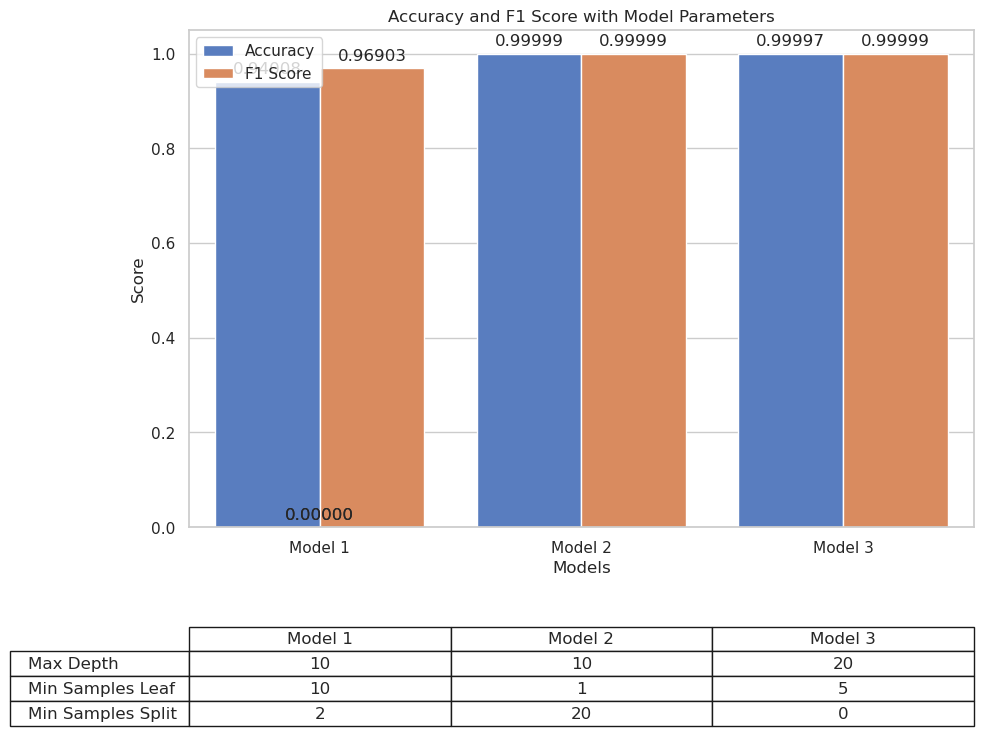

In [156]:
# Creating the bar plot using seaborn
plt.figure(figsize=(10, 8))

# Plotting Accuracy and F1 Score side by side for each model
df_melted = pd.melt(results_df, id_vars='Model', value_vars=['Accuracy', 'F1 Score'], var_name='Metric', value_name='Score')

ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted)
# Adding values on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.5f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), textcoords = 'offset points')


# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score with Model Parameters')
plt.legend(loc='upper left')

# Displaying the table below the plot
plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index, cellLoc='center', loc='bottom', bbox=[0, -0.4, 1, 0.2])

# Adjust layout to make room for the table
plt.tight_layout()

# Display the plot
plt.show()

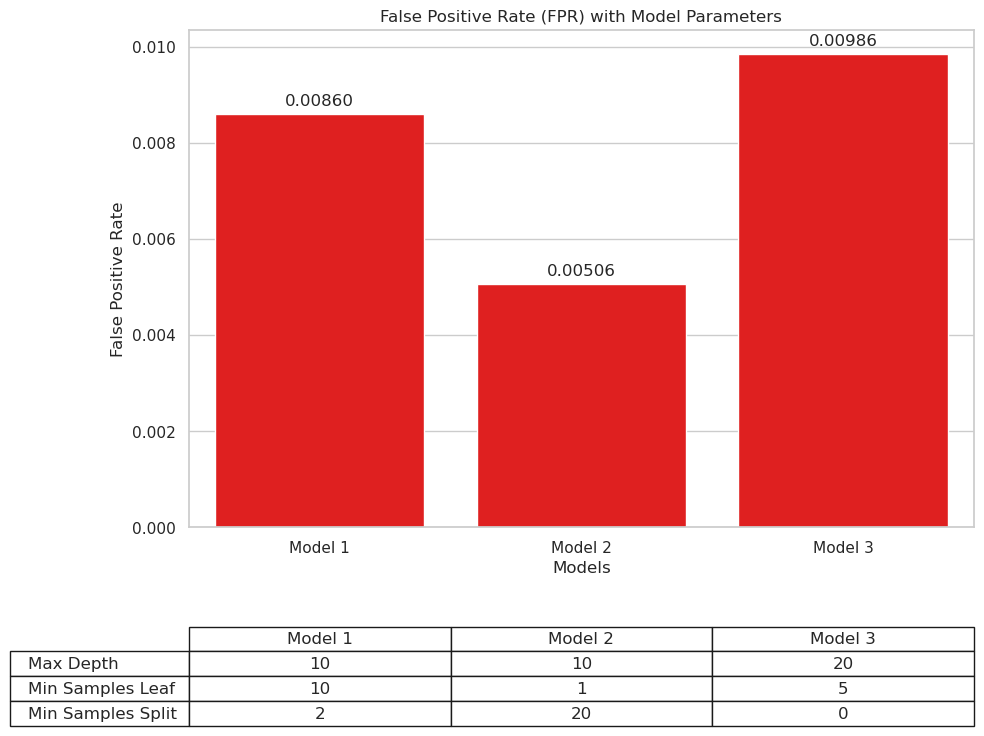

In [155]:
# Creating the bar plot using seaborn for FPR
plt.figure(figsize=(10, 8))

# Plotting FPR with grey color
ax = sns.barplot(x='Model', y='False Positive Rate (FPR)', data=results_df, color='red')

# Adding values on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.5f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), textcoords = 'offset points')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate (FPR) with Model Parameters')

# Displaying the table below the plot
plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index, cellLoc='center', loc='bottom', bbox=[0, -0.4, 1, 0.2])

# Adjust layout to make room for the table
plt.tight_layout()

# Display the plot
plt.show()

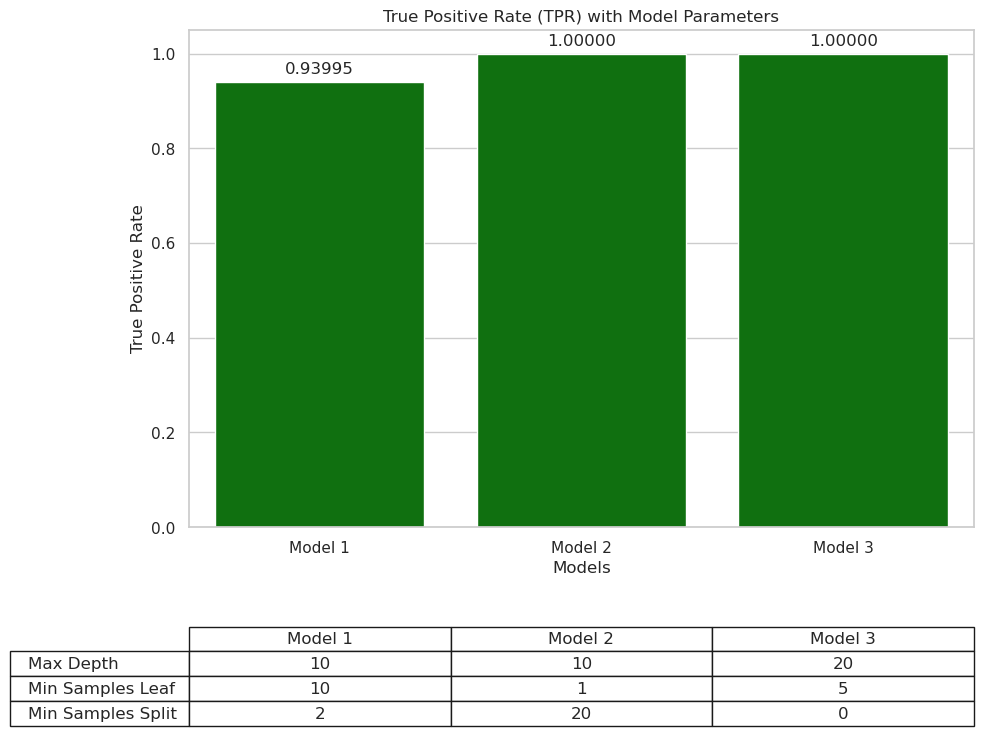

In [158]:
# Creating the bar plot using seaborn for TPR
plt.figure(figsize=(10, 8))

# Plotting FPR with grey color
ax = sns.barplot(x='Model', y='True Positive Rate (TPR)', data=results_df, color='green')

# Adding values on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.5f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), textcoords = 'offset points')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('True Positive Rate')
plt.title('True Positive Rate (TPR) with Model Parameters')

# Displaying the table below the plot
plt.table(cellText=table_data.values, colLabels=table_data.columns, rowLabels=table_data.index, cellLoc='center', loc='bottom', bbox=[0, -0.4, 1, 0.2])

# Adjust layout to make room for the table
plt.tight_layout()

# Display the plot
plt.show()